Run all the dependecis needed for this project


In [7]:
import pandas as pd
import numpy as np
import re, string
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
!pip install langdetect deep-translator
from langdetect import detect
from deep_translator import GoogleTranslator
import time
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from tensorflow.keras.callbacks import Callback

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Mounting google drive to access the dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load all the Datasets, such as Train, Test & Validation

In [9]:
train_dataset = pd.read_csv('/content/drive/MyDrive/SM_TECHNOLOGY_DATASET/SM_TECHNOLOGY_DATASET/DATASET/train.csv')
test_dataset = pd.read_csv('/content/drive/MyDrive/SM_TECHNOLOGY_DATASET/SM_TECHNOLOGY_DATASET/DATASET/test.csv')
validation_dataset = pd.read_csv('/content/drive/MyDrive/SM_TECHNOLOGY_DATASET/SM_TECHNOLOGY_DATASET/DATASET/validation.csv')

**Step 1: Exploratory Data Analysis (EDA)**

Seeing the shape off given dataset

In [10]:
train_dataset.shape

(23473, 8)

In [11]:
test_dataset.shape

(6000, 3)

In [12]:
validation_dataset.shape

(840, 4)

Seeing the info of dataset

In [13]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23473 entries, 0 to 23472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             23473 non-null  object
 1   feedback_text  23473 non-null  object
 2   toxic          23473 non-null  int64 
 3   abusive        23473 non-null  int64 
 4   vulgar         23473 non-null  int64 
 5   menace         23473 non-null  int64 
 6   offense        23473 non-null  int64 
 7   bigotry        23473 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB


In [14]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6000 non-null   int64 
 1   content  6000 non-null   object
 2   lang     6000 non-null   object
dtypes: int64(1), object(2)
memory usage: 140.8+ KB


In [15]:
validation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             840 non-null    int64 
 1   feedback_text  840 non-null    object
 2   lang           840 non-null    object
 3   toxic          840 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 26.4+ KB


Checking, is there any null valur or not

In [16]:
train_dataset.isnull().sum()

,0
id,0
feedback_text,0
toxic,0
abusive,0
vulgar,0
menace,0
offense,0
bigotry,0


In [17]:
test_dataset.isnull().sum()

,0
id,0
content,0
lang,0


In [18]:
validation_dataset.isnull().sum()

,0
id,0
feedback_text,0
lang,0
toxic,0


**Due to GPU limitations and to ensure proper training and testing, I have sampled a subset of data from the training, validation, and test datasets. Below are a few example rows from each set.**

In [19]:
train_file = train_dataset.head(10000)
train_file.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [20]:
test_file = test_dataset.head(2000)
test_file.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [21]:
validation_file = validation_dataset.head(800)
validation_file.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


Dropping unnecessary columns for all dataset

In [22]:
train_file.drop(columns=['id'], inplace=True)
test_file.drop(columns=['lang'], inplace=True)
validation_file.drop(columns=['id', 'lang'], inplace=True)

<ipython-input-22-a9699d53e748>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_file.drop(columns=['id'], inplace=True)
<ipython-input-22-a9699d53e748>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_file.drop(columns=['lang'], inplace=True)
<ipython-input-22-a9699d53e748>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_file.drop(columns=['id', 'lang'], inplace=True)


Seeing the Correlation Matrix of train dataset

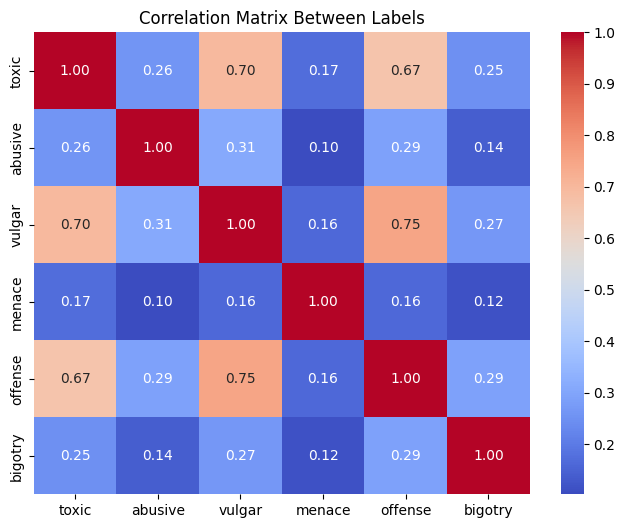

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
corr_matrix = train_file[label_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Between Labels")
plt.show()

Co-occurance of toxicity with other labels

In [24]:
toxic_co_counts = {}
for col in label_cols:
    if col != 'toxic':
        toxic_co_counts[col] = ((train_dataset['toxic'] == 1) & (train_dataset[col] == 1)).sum()
co_occurs_df = pd.DataFrame.from_dict(toxic_co_counts, orient='index', columns=['Co-occurrence with Toxic'])
co_occurs_df = co_occurs_df.sort_values(by='Co-occurrence with Toxic', ascending=False)

<ipython-input-25-32961d5f964b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=co_occurs_df.index, y='Co-occurrence with Toxic', data=co_occurs_df, palette='Reds')


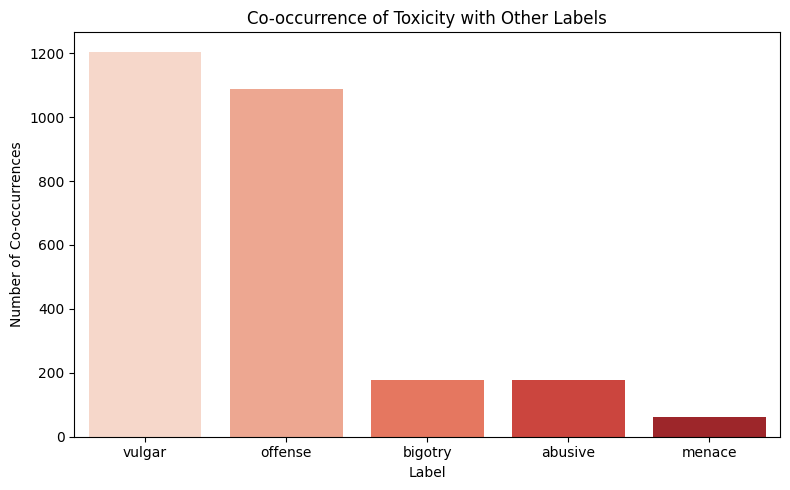

In [25]:
plt.figure(figsize=(8, 5))
sns.barplot(x=co_occurs_df.index, y='Co-occurrence with Toxic', data=co_occurs_df, palette='Reds')
plt.title('Co-occurrence of Toxicity with Other Labels')
plt.ylabel('Number of Co-occurrences')
plt.xlabel('Label')
plt.tight_layout()
plt.show()

**Step 2 :Text Preprocessing**

Building the language translation function

In [26]:
def translate_if_not_english(text):
    try:
        lang = detect(str(text))
        if lang != 'en':
            time.sleep(1)
            return GoogleTranslator(source='auto', target='en').translate(text)
        else:
            return text
    except:
        return text

Translating the text

In [27]:
train_file.loc[:, 'feedback_text'] = train_file['feedback_text'].apply(translate_if_not_english)
test_file.loc[:, 'content'] = test_file['content'].apply(translate_if_not_english)
validation_file.loc[:, 'feedback_text'] = validation_file['feedback_text'].apply(translate_if_not_english)

After translation all the dataset look like!

In [28]:
train_file.head()

,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,"""Agustina Barrientos]] \n | | Piceiro model \n...",0,0,0,0,0,0
3,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [29]:
test_file.head()

,id,content
0,0,A Viki writer as 12th Doctor added his name to...
1,1,"It is possible, but I do not yet see the need ..."
2,2,"So you are one of the conservative ones, who p..."
3,3,"Unfortunately, it was not done, but there was ..."
4,4,: Picture: Source Problem in seldabagcan.jpg: ...


In [30]:
validation_file.head()

,feedback_text,toxic
0,Well okay. We improve the Balkans substance an...,0
1,"By God, and John Lennon's song: http://www.you...",1
2,"Hi. First of all, I congratulate you ... In th...",0
3,Read all the discussions. Maybe delete and get...,1
4,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,1


Preprocessing full function

In [31]:
def preprocess(text):
    text = text.lower().strip()
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'https?://(?:www\.)?\S+|www\.\S+', '', text)
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('[math]', '')
    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)
    contractions = {
        "can't": "can not", "won't": "will not", "i'm": "i am", "it's": "it is", "you're": "you are",
        "they're": "they are", "we're": "we are", "isn't": "is not", "aren't": "are not",
        "wasn't": "was not", "weren't": "were not", "doesn't": "does not", "don't": "do not",
        "didn't": "did not", "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
        "wouldn't": "would not", "shouldn't": "should not", "couldn't": "could not",
        "mightn't": "might not", "mustn't": "must not",
        "let's": "let us", "that's": "that is", "who's": "who is", "what's": "what is",
        "here's": "here is", "there's": "there is", "how's": "how is",
        "i've": "i have", "we've": "we have", "you've": "you have", "they've": "they have",
        "i'll": "i will", "you'll": "you will", "he'll": "he will", "she'll": "she will", "we'll": "we will",
        "they'll": "they will", "i'd": "i would", "you'd": "you would", "he'd": "he would",
        "she'd": "she would", "we'd": "we would", "they'd": "they would"
    }

    words = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        words.append(word)
    text = ' '.join(words)
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

Applying preprocess

In [32]:
train_file.loc[:, 'feedback_text'] = train_file['feedback_text'].apply(preprocess)
test_file.loc[:, 'content'] = test_file['content'].apply(preprocess)
validation_file.loc[:, 'feedback_text'] = validation_file['feedback_text'].apply(preprocess)

Lemmatization : Word convert into root word itself

In [33]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train_file.loc[:, 'feedback_text'] = train_file['feedback_text'].apply(lemmatize_text)
test_file.loc[:, 'content'] = test_file['content'].apply(lemmatize_text)
validation_file.loc[:, 'feedback_text'] = validation_file['feedback_text'].apply(lemmatize_text)

Tokenization with DistilBERT

In [34]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
def encode_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Apply tokenization

In [35]:
x_train_encode = encode_texts(train_file["feedback_text"], tokenizer)
x_valid_encode = encode_texts(validation_file["feedback_text"], tokenizer)
x_test_encode = encode_texts(test_file["content"], tokenizer)
y_train = train_file["toxic"].values
y_valid = validation_file["toxic"].values

**Step 3: Model Creation**

Model Building

In [36]:
class ToxicOnlyRocAucCallback(Callback):
    def __init__(self, validation_data):
        self.X_val, self.y_val = validation_data
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        toxic_pred = y_pred[:, 0]
        score = roc_auc_score(self.y_val, toxic_pred)
        print(f"\n ROC-AUC (toxic only) - epoch: {epoch + 1} - score: {score:.6f}")

def build_model(transformer_layer, max_len=128):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        outputs = transformer_layer(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]

    cls_token = Lambda(extract_cls_token, output_shape=(768,), name="extract_cls_token")([input_ids, attention_mask])
    x = Dropout(0.3)(cls_token)
    x = Dense(1, activation="sigmoid")(x)
    return Model(inputs=[input_ids, attention_mask], outputs=x)
transformer_layer = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
model = build_model(transformer_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Train the model

In [37]:
history = model.fit(
    x={"input_ids": x_train_encode["input_ids"], "attention_mask": x_train_encode["attention_mask"]},
    y=y_train,
    validation_data=(
        {"input_ids": x_valid_encode["input_ids"], "attention_mask": x_valid_encode["attention_mask"]},
        y_valid
    ),
    epochs=12,
    batch_size=16,
    callbacks=[ToxicOnlyRocAucCallback(validation_data=(
        {"input_ids": x_valid_encode["input_ids"], "attention_mask": x_valid_encode["attention_mask"]},
        y_valid
    ))]
)

Epoch 1/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2426 - loss: 0.9804
 ROC-AUC (toxic only) - epoch: 1 - score: 0.626133
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - accuracy: 0.2428 - loss: 0.9801 - val_accuracy: 0.8338 - val_loss: 0.5638
Epoch 2/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8569 - loss: 0.4753
 ROC-AUC (toxic only) - epoch: 2 - score: 0.648430
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.8570 - loss: 0.4752 - val_accuracy: 0.8450 - val_loss: 0.4309
Epoch 3/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9010 - loss: 0.3564
 ROC-AUC (toxic only) - epoch: 3 - score: 0.674699
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9010 - loss: 0.3563 - val_accuracy: 0.8450 - val_loss: 0.4153
Epoch 4/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9026 - loss: 0.3189
 ROC-AUC (toxic only) - epoch: 4 - score: 0.708353
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 71ms/step - accuracy: 0.9026 - loss: 0.3188 - val_accuracy

Model prediction

In [38]:
predictions = model.predict({
    "input_ids": x_test_encode["input_ids"],
    "attention_mask": x_test_encode["attention_mask"]
})

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step


Convert to binary predictions

In [46]:
toxic_preds = (predictions > 0.1).astype(int).flatten()

Final Output

In [47]:
output_df = test_file.copy()
output_df["toxic_predicted"] = toxic_preds

In [48]:
output_df.head()

,id,content,toxic_predicted
0,0,a viki writer a 12th doctor added his name to ...,0
1,1,it is possible but i do not yet see the need t...,0
2,2,so you are one of the conservative one who pre...,1
3,3,unfortunately it wa not done but there wa some...,0
4,4,picture source problem in seldabagcanjpg pictu...,0


In [49]:
output_df.value_counts()

,,,count
id,content,toxic_predicted,
1983,hello and thank you for your contribution to the article orientation race unfortunately this modification ha been canceled and prevent your next contribution from being canceled to familiarize yourself with syntax do not hesitate to use the sandbox if you believe that this deletion is unjustified do not hesitate to i wish you good future contribution on wikipedia a question about the operation of wikipedia contact the new forum the pro of 94 discus,0,1
1982,it is still crazy to see these people in the starting block behind their keyboard waiting for the slightest rumor to modify the article jacques chirac without waiting for net confirmation of information like vulture to have the vile honor to have their name engraved in the history of the change in the article and to be able to say it is moaaa who ha inserted this ultra important information in this article poor vulture shame on you you are not better than christine boutin and her tweet and that is not a compliment coming from me,1,1
1981,it is interesting but how the local population reacts to such community if it support it probably make no sense to buy a house in such a village i am a believing person although i rarely go to the church in my opinion god should be in my soul and not measure with kilogram of gold hanging in the form of a cross on the belly killer thief liar and tray and such an abomination build his community in my opinion the next schizophrenic if they are such satanist why i do not see them in the donbas in my opinion their place here on which side is this their business but here death blood fear horror and pain are pouring where are they another patient and people are listening to some kind of idiot in their lack of education and stupidity it is a pity it seems like an interesting village in history but in fact probably the future of this village decline and devastation a in the head of these people who create such a community sincerely sorry,1,1
1980,first of all it is definitely a very nice thing to value animal so much congratulation however the information i created in olymposs blood wa completely encyclopedic you can finalize it proven by any rick riordan fan i would be glad if you return to me a soon a possible about why it wa deleted enjoy your work helloepercyannabethnicopipergasonhazelfrachellukereyna hi thank you for your nice comment when i take a look at the matter again i see that it is not written in an encyclopedic style and way if you create the page by examining similar substance it will be acceptable good work théoden message,0,1
1979,i suggest a giant and penetrating reading in objectivity which the gala gay and maitê proença ha all that huge text to say that castle have defense i wa told that humanoid have one less screw on the head and you only served to really check the history ah i also suggest another reading in label because you offended me good luck to you and your friend in fact when some people get embarrassed with something they have always done put the blame for the friend know a friend of mine enjoy the architect tour a lot is it in rj enjoy gal it should happen only at carnival right i love maitê excellent journalist delicious contribution peterlouiz discussion,0,1
...,...,...,...
4,picture source problem in seldabagcanjpg picture thank you for uploading the picture seldabagcanjpg however there is no detailed information about who the content is made on the definition page of the file ie the copyright status is not clear if you have not made the file yourself you should specify the owner of the content if you have obtained it from a website give a link that clearly show where you bought it if you want to check the picture you have uploaded click this link non welded and unlicensed picture are deleted one week after marked a specified in the quick deletion criterion picture of copyright are reserved and do not comply with fair use policy are deleted after 48 hour wikipedia for your 